There are 9999 rows and 8 columns
Explained variation per principal component: [0.18934872 0.13336505]
Cumulative variance explained by 2 principal components: 32.27%
optimum num of clusters = 9


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


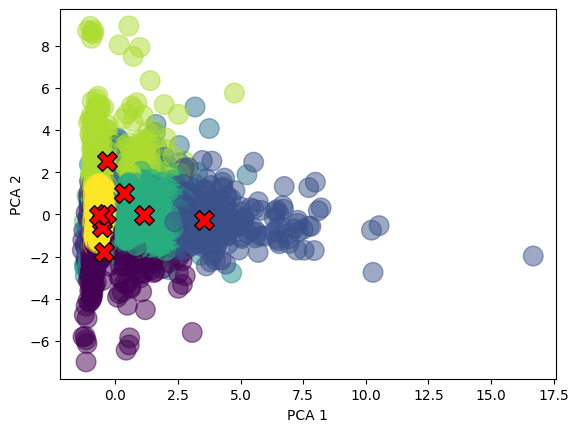

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans

def load_data(file_name):
    with open(file_name) as f:
        ds = json.load(f)

    columns = ds['columns']
    distributions = ds['distributions']
    indexes = []

    for distribution in distributions:
        indexes.append(distribution['tokenId'])

    data = pd.DataFrame(columns=[*columns], index=indexes)

    for index, token in enumerate(data.index):
        data.loc[token] = distributions[index]['totalScoreDistribution']
    
    return data

def load_embeddings(file_name):
    # Load data
    distributions_raw = load_data(file_name)

    # Check data shape
    row, col = distributions_raw.shape
    print(f'There are {row} rows and {col} columns') 
    # print(distributions_raw.head(10))

    # Work on copy of data
    raw_data_scaled = distributions_raw.copy()

    # Scaling the data to keep the different attributes in same range.
    raw_data_scaled[raw_data_scaled.columns] = StandardScaler().fit_transform(raw_data_scaled)
    # print(raw_data_scaled.describe())

    return raw_data_scaled

def pca_embeddings(df_scaled):
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(df_scaled)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
        np.sum(pca.explained_variance_ratio_)))

    # Results from pca.components_
    # dataset_pca = pd.DataFrame(abs(pca.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2'])
    # print('\n\n', dataset_pca)
    
    # print("\n*************** Most important features *************************")
    # print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
    # print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
    # print("\n******************************************************************")

    return pca_result, pca

def kmean_hyper_param_tuning(data):
    # Candidate values for our number of cluster
    parameters = [5, 6, 7, 8, 9, 10]

    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()
    silhouette_scores = []

    # Evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)   
        kmeans_model.fit(data)

        ss = metrics.silhouette_score(data, kmeans_model.labels_)
        silhouette_scores += [ss]

        # print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # Plotting silhouette score
    # plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    # plt.xticks(range(len(silhouette_scores)), list(parameters))
    # plt.title('Silhouette Score', fontweight='bold')
    # plt.xlabel('Number of Clusters')
    # plt.show()

    return best_grid['n_clusters']


def visualizing_results(pca_result, label, centroids_pca):
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    plt.scatter(x, y, c=label, alpha=0.5, s=200)  # plot different colors per cluster
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1,
                color='red', edgecolors="black", lw=1)

    plt.show()

def main():
    data_scaled = load_embeddings('../score_distributions/BAYC_totalScoreDistribution.json')

    pca_result, pca_2 = pca_embeddings(data_scaled)

    optimum_num_clusters = kmean_hyper_param_tuning(data_scaled)
    print("optimum num of clusters =", optimum_num_clusters)

    kmeans = KMeans(
        n_clusters=optimum_num_clusters, 
        init="k-means++", 
        n_init=50,
        max_iter=500,
        random_state=42)
    kmeans.fit(data_scaled)
    centroids = kmeans.cluster_centers_
    centroids_pca = pca_2.transform(centroids)

    visualizing_results(pca_result, kmeans.labels_, centroids_pca)

main()
